In [1]:
from __future__ import division, print_function
import os
import sys
import numpy as np
import pandas as pd
import src.preprocessing as preprocessing
from src.preprocessing import preprocess, preprocess_players
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV, Lasso
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.preprocessing import PolynomialFeatures
from src.build_db import connect
from src.db_helpers import parse_date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from scipy.sparse import coo_matrix, csc_matrix, hstack
warnings.filterwarnings("ignore")

In [2]:
# connect to db
db_name = 'dota_db'
with open(os.path.expanduser('~/.pgpass')) as f:
    for line in f:
        host, port, db, user, password = [x.strip() for x in line.split(':')]
        if db == db_name:
            dota_con, meta = connect(user=user, password=password, db=db, host=host, port=port)
            break

In [19]:
query = '''
SELECT match_id, picks_bans, radiant_win FROM matches WHERE duration >= 900;
'''
df = pd.read_sql(query, dota_con)

In [7]:
df = preprocess(df)

> /home/ubuntu/dota-draft-coach/src/preprocessing.py(14)parse_pb()
-> picks = pb_df[pb_df['is_pick']]
(Pdb) pb_list
(Pdb) pb_list[0]
*** TypeError: 'NoneType' object has no attribute '__getitem__'
(Pdb) q


BdbQuit: 

In [20]:
t = df['picks_bans'].map(lambda x: 0 if not x else len(x))
mask = t == 20

In [22]:
df = df[mask]

In [24]:
df = preprocess(df)

In [25]:
y = df['team1_win'].values
X = df.drop(['team1_win', 'match_id'], axis=1).values

In [26]:
def polynomial_features(X):
    X_sparse = csc_matrix(X)
    sparse_product = []
    for i in xrange(X.shape[1] -1 ):
        for j in xrange(i, X.shape[1]):
            sparse_product.append(X_sparse[:, i].multiply(X_sparse[:, j]))
    X_sparse_poly = hstack(sparse_product)
    return X_sparse_poly

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5000)

In [28]:
X_poly_train = polynomial_features(X_train)
X_poly_test = polynomial_features(X_test)

# Gradient Boosting

In [13]:
gb = XGBClassifier(n_estimators=1000, n_jobs=-1, max_depth=10)
gb.fit(X_train, y_train)
gb.score(X_test, y_test)

0.54120000000000001

In [14]:
gb.score(X_train, y_train)

0.99408342616660483

###### Polynomial features

In [15]:
gb = XGBClassifier(n_estimators=1000, n_jobs=-1)
gb.fit(X_poly_train, y_train)
gb.score(X_poly_test, y_test)

0.54800000000000004

In [16]:
gb.score(X_poly_train, y_train)

0.70880059413293728

In [33]:
gb = XGBClassifier(n_estimators=1000, n_jobs=-1, cv=5)
cross_val_score(gb, X, y).mean()

0.57761105156603543

# Random Forests

In [83]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, )
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.624

In [84]:
rf.score(X_train, y_train)

0.99998336964294621

In [35]:
cross_val_score(RandomForestClassifier(n_estimators=500, n_jobs=-1), X, y, cv=5).mean()

0.57246599153647015

###### Polynomial features

In [85]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, )
rf.fit(X_poly_train, y_train)
rf.score(X_poly_test, y_test)

0.62860000000000005

In [86]:
rf.score(X_poly_train, y_train)

0.99998336964294621

In [19]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, )
cross_val_score(rf, X, y, cv=5).mean()

0.53809890957153872

In [36]:
cross_val_score(LogisticRegression(C=.01), X, y, cv=5).mean()

0.58373196813652872

In [24]:
X_poly = polynomial_features(X)

In [38]:
X_poly = polynomial_features(X)

In [42]:
cross_val_score(LogisticRegression(C=.1), X_poly, y, cv=5).mean()

0.56131921573351007

# Ridge Regression

In [87]:
ridge = RidgeClassifier(alpha=1000, fit_intercept=False)
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

0.627

In [88]:
ridge.score(X_train, y_train)

0.62621609485955665

###### Polynomial Features

In [89]:
ridge = RidgeClassifier(alpha=1000)
ridge.fit(X_poly_train, y_train)
ridge.score(X_poly_test, y_test)

0.63539999999999996

In [90]:
ridge.score(X_poly_train, y_train)

0.67930019457517754

In [91]:
ridge.intercept_

array([ 0.1408771])

# Flipping Teams

In [92]:
high_skill_df.head()

,match_id,radiant_win,radiant_1,radiant_2,radiant_3,radiant_4,radiant_5,radiant_6,radiant_7,radiant_8,...,dire_105,dire_106,dire_107,dire_108,dire_109,dire_110,dire_111,dire_112,dire_113,dire_114
0,3470130536,False,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,3470130574,True,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3470130667,True,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,3470130732,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3470130756,True,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
X_dire = np.concatenate([X_train[:, 114:], X_train[:, :114], np.ones((X_train.shape[0],1))], axis=1)
X_radiant = np.concatenate([X_train, np.zeros((X_train.shape[0], 1))], axis=1)
y_dire = ~y_train

In [94]:
X_train_sym = np.concatenate([X_radiant, X_dire], axis=0)
y_train_sym = np.concatenate([y_train, y_dire], axis=0)
X_test_sym = np.concatenate([X_test, np.zeros((X_test.shape[0], 1))], axis=1)

In [95]:
lr = RidgeClassifier(alpha=1000)
lr.fit(X_train_sym, y_train_sym)
lr.score(X_test_sym, y_test)

0.625

In [ ]:
lr.predict_proba()

In [11]:
X_teams = np.concatenate([X, np.zeros((X.shape[0], 1))], axis=1)

In [26]:
def sym_score(estimator, X, y):
    X_flipped = np.concatenate([ X[:, 114:-1], X[:, :114], np.abs(X[:, -1].reshape(-1,1) - 1) ], axis=1)
    p1 = estimator.predict_proba(X)[:, 1]
    p2 = estimator.predict_proba(X_flipped)[:, 1]
    p = (p1 + p2) / 2.0
    predictions = p > .5
    return accuracy_score(y, predictions)

In [30]:
lr = LogisticRegression()

In [33]:
cross_val_score(lr, X_teams, y, scoring=sym_score, cv=5).mean()

0.56767127125752548

In [34]:
cross_val_score(LogisticRegression(), X, y, cv=5).mean()

0.62423416654056907

# Synergy and Countering features

In [82]:
def synergy_matrix(X, y):
    winrates = np.ones((114,114)) * .5
    for i in xrange(0, 113):
        for j in xrange(i + 1, 114):
            radiant_matches = (X[:, i] == 1) & (X[:, j + 114] == 1)
            dire_matches = (X[:, j] == 1) & (X[:, i + 114] == 1)
            try:
                wr = (y[radiant_matches].sum() +\
                    (y[dire_matches].shape[0] - y[dire_matches].sum()) )\
                    / (radiant_matches.sum() + dire_matches.sum())
            except ZeroDivisionError:
                wr = .5
            if np.isnan([wr]):
                wr = .5
            winrates[i, j] = wr
            winrates[j, i] = wr
    return winrates

In [80]:
def counter_matrix(X, y):
    winrates = np.ones((114, 114)) * .5
    for i in xrange(0, 113):
        for j in xrange(i + 1, 114):
            radiant_matches = (X[:, i] == 1) & (X[:, j + 114] == 1)
            dire_matches = (X[:, j] == 1) & (X[:, i + 114] == 1)
    

In [83]:
x = synergy_matrix(X, y)

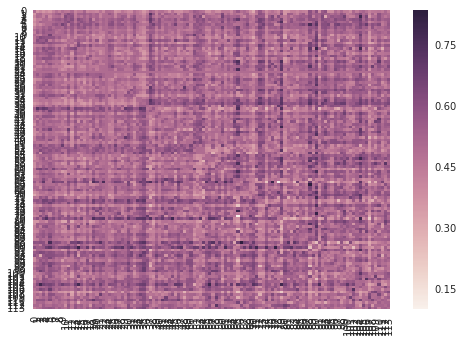

In [84]:
sns.heatmap(x)
plt.show()

In [ ]:
def calculate_synergy(X_i, sm):
    
def preprocess_synergy(X, sm):
    radiant = X[:, :114]
    dire = X[:, 114:]
    

In [11]:
X_poly = polynomial_features(X)
cross_val_score(LogisticRegression(C=.01), X_poly, y).mean()

0.62679810958045146